(example_2)=
# Example 2: Estimating the mean and precision of a time-varying Gaussian distributions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

from pyhgf.model import Network

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Where the standard continuous HGF assumes a known precision in the input node (usually set to something high), this assumption can be relaxed and the filter can also try to estimate this quantity from the data. In this notebook, we demonstrate how we can infer the value of the mean, of the precision, or both value at the same time, using the appropriate value and volatility coupling parents.

## Unkown mean, known precision

```{hint}
The {ref}`continuous_hgf` is an example of a model assuming a continuous input with known precision and unknown mean. It is further assumed that the mean is changing overtime, and we want the model to track this rate of change by adding a volatility node on the top of the value parent (two-level continuous HGF), and event track the rate of change of this rate of change by adding another volatility parent (three-level continuous HGF).
```

In [3]:
np.random.seed(123)
dist_mean, dist_std = 5, 1
input_data = np.random.normal(loc=dist_mean, scale=dist_std, size=1000)

In [4]:
mean_hgf = (
    Network()
    .add_nodes(precision=1.0, autoconnection_strength=0)
    .add_nodes(value_children=0, tonic_volatility=-8.0)
    .input_data(input_data)
)

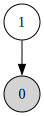

In [5]:
mean_hgf.plot_network()

```{note}
We are setting the tonic volatility to something low for visualization purposes, but changing this value can make the model learn in fewer iterations.
```

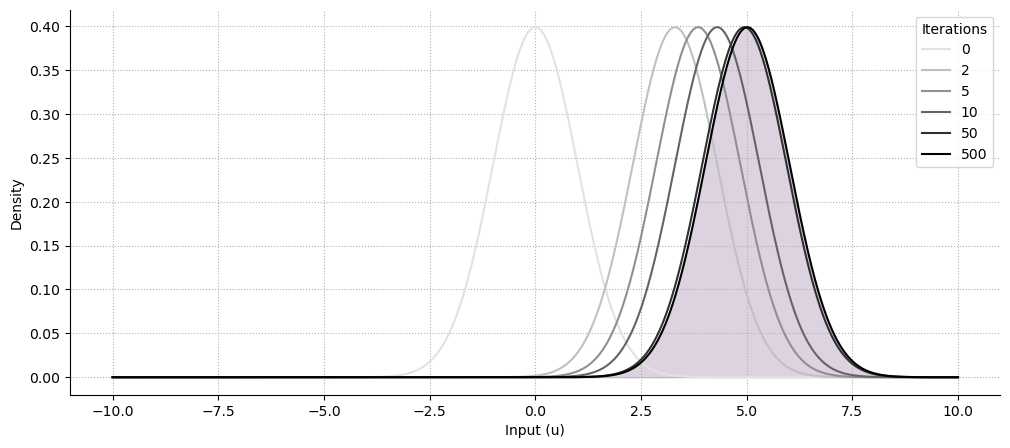

In [6]:
# get the nodes trajectories
fig, ax = plt.subplots(figsize=(12, 5))

x = np.linspace(-10, 10, 1000)
for i, color in zip([0, 2, 5, 10, 50, 500], plt.cm.Greys(np.linspace(0.2, 1, 6))):

    # extract the sufficient statistics from the input node (and parents)
    mean = mean_hgf.node_trajectories[0]["expected_mean"][i]
    std = np.sqrt(1 / (mean_hgf.attributes[0]["expected_precision"]))

    # the model expectations
    ax.plot(x, norm(mean, std).pdf(x), color=color, label=i)

# the sampling distribution
ax.fill_between(x, norm(dist_mean, dist_std).pdf(x), color="#582766", alpha=0.2)

ax.legend(title="Iterations")
ax.set_xlabel("Input (u)")
ax.set_ylabel("Density")
plt.grid(linestyle=":")
sns.despine()

## Kown mean, unknown precision

## Unkown mean, unknown precision

In [7]:
np.random.seed(123)
dist_mean, dist_std = 5, 1
input_data = np.random.normal(loc=dist_mean, scale=dist_std, size=1000)

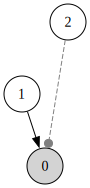

In [8]:
mean_precision_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(value_children=0, tonic_volatility=-6.0)
    .add_nodes(volatility_children=0, mean=6.0, tonic_volatility=-8.0)
).input_data(input_data)
mean_precision_hgf.plot_network()

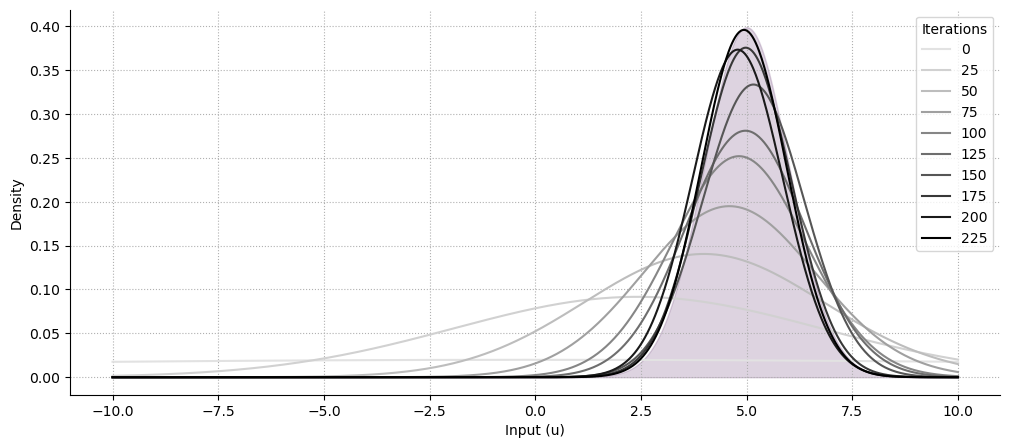

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))

x = np.linspace(-10, 10, 1000)
for i, color in zip(range(0, 250, 25), plt.cm.Greys(np.linspace(0.2, 1, 10))):

    # extract the sufficient statistics from the input node (and parents)
    mean = mean_precision_hgf.node_trajectories[0]["expected_mean"][i]
    std = np.sqrt(1 / mean_precision_hgf.node_trajectories[0]["expected_precision"][i])

    # the model expectations
    ax.plot(x, norm(mean, std).pdf(x), color=color, label=i)

# the sampling distribution
ax.fill_between(x, norm(dist_mean, dist_std).pdf(x), color="#582766", alpha=0.2)

ax.legend(title="Iterations")
ax.set_xlabel("Input (u)")
ax.set_ylabel("Density")
plt.grid(linestyle=":")
sns.despine()

## System configuration

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Sep 26 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.4
jax   : 0.4.33
jaxlib: 0.4.33

IPython   : 8.23.0
numpy     : 1.26.0
matplotlib: 3.8.4
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
seaborn   : 0.13.2

Watermark: 2.4.3

